In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

df_eddies = pd.read_pickle('/srv/scratch/z5297792/Clim_data/df_eddies_processed.pkl')
with open('/srv/scratch/z5297792/Clim_data/Sample_Data/dic_sample_vert_info.pkl', 'rb') as f:
    dic_sample = pickle.load(f)
sample_eddies = [8, 896, 2504, 2749, 382, 926, 1394, 1967]

import sys
sys.path.append("/home/z5297792/UNSW-MRes/MRes/modules") 
from utils import plot_ellipse, smooth

Rc_max = 10


In [2]:
import netCDF4 as nc
from scipy.interpolate import griddata
import netCDF4 as nc
from scipy.interpolate import RegularGridInterpolator
import time

# Field Data

fname = f'/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'

dataset = nc.Dataset(fname)

lon_rho = np.transpose(dataset.variables['lon_rho'], axes=(1, 0))
lat_rho = np.transpose(dataset.variables['lat_rho'], axes=(1, 0))
mask_rho = np.transpose(dataset.variables['mask_rho'], axes=(1, 0))
h =  np.transpose(dataset.variables['h'], axes=(1, 0))
angle = dataset.variables['angle'][0, 0]
z_r = np.load('/srv/scratch/z5297792/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))[150, 150, :]

def distance(lat1, lon1, lat2, lon2):
    EARTH_RADIUS = 6357
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat, dlon = lat2 - lat1, lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return EARTH_RADIUS * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

j_mid = lon_rho.shape[1] // 2
i_mid = lon_rho.shape[0] // 2

dx = distance(lat_rho[:-1, j_mid], lon_rho[:-1, j_mid],
              lat_rho[1:, j_mid], lon_rho[1:, j_mid])
dy = distance(lat_rho[i_mid, :-1], lon_rho[i_mid, :-1],
              lat_rho[i_mid, 1:], lon_rho[i_mid, 1:])

x_grid = np.insert(np.cumsum(dx), 0, 0)
y_grid = np.insert(np.cumsum(dy), 0, 0)
X_grid, Y_grid = np.meshgrid(x_grid, y_grid, indexing='ij')

res = 1  # 1 km resolution
x_new = np.arange(0, x_grid[-1], res)
y_new = np.arange(0, y_grid[-1], res)
X_new, Y_new = np.meshgrid(x_new, y_new, indexing='ij')
new_points = np.column_stack((X_new.ravel(), Y_new.ravel()))

interp_lon = RegularGridInterpolator((x_grid, y_grid), lon_rho,
                                     method='linear', bounds_error=False, fill_value=np.nan)
interp_lat = RegularGridInterpolator((x_grid, y_grid), lat_rho,
                                     method='linear', bounds_error=False, fill_value=np.nan)

lon_new = interp_lon(new_points).reshape(len(x_new), len(y_new))
lat_new = interp_lat(new_points).reshape(len(x_new), len(y_new))


#### Side Profiles

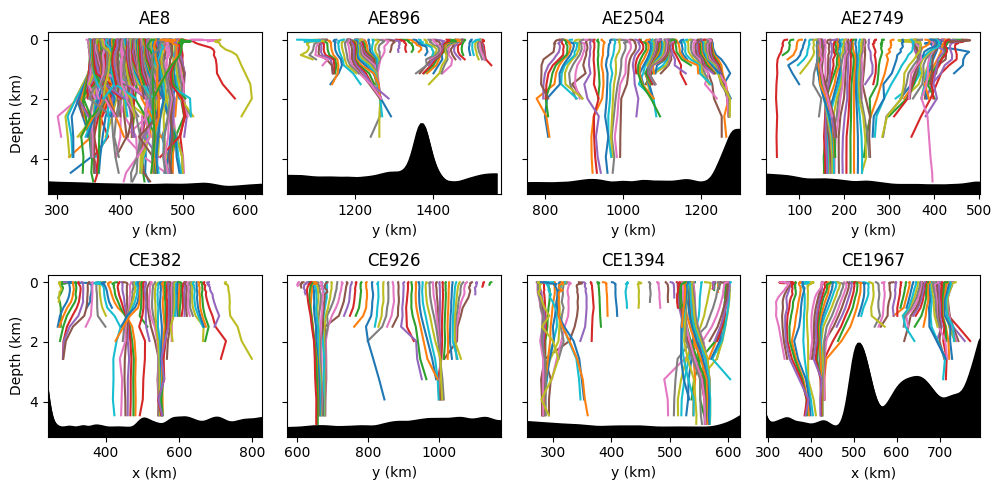

In [3]:
fig, axs = plt.subplots(2, 4, figsize=(10,5), sharey=True)
df_means = pd.DataFrame([
    {
        'Eddy': eddy,
        'x_mean': df_all['x'].mean(),
        'y_mean': df_all['y'].mean()
    }
    for eddy, days in dic_sample.items()
    for df_all in [pd.concat(
        [df0 for df0 in days.values() 
         if not df0.empty and not df0.isna().all().all()],
        ignore_index=True
    )]
])

for e, eddy in enumerate(dic_sample.keys()):
    ax = axs[e // 4, e % 4]
    dic = dic_sample[eddy]
    pmean = df_means[df_means['Eddy']==eddy].iloc[0]
    for d, day in enumerate(dic.keys()):
        df = dic[day].copy()
        if ('1967' in eddy) or ('382' in eddy):
            ax.plot(df['x'], -df['Depth']/1000)
            ax.set_xlabel('x (km)')
        else:
            ax.plot(df['y'], -df['Depth']/1000)
            ax.set_xlabel('y (km)')
    xlim = ax.get_xlim()
    
    if ('1967' in eddy) or ('382' in eddy):
        jc = np.where(np.abs(pmean['y_mean']-y_grid)==np.min(np.abs(pmean['y_mean']-y_grid)))[0][0]
        ax.plot(x_grid, h[:, jc]/1000, 'k')
    else:
        ic = np.where(np.abs(pmean['x_mean']-x_grid)==np.min(np.abs(pmean['x_mean']-x_grid)))[0][0]
        ax.plot(y_grid, h[ic, :]/1000, 'k')

    ylim = ax.get_ylim()

    if ('1967' in eddy) or ('382' in eddy):
        jc = np.where(np.abs(pmean['y_mean'] - y_grid) == np.min(np.abs(pmean['y_mean'] - y_grid)))[0][0]
        ax.fill_between(x_grid, h[:, jc] / 1000, 10, color='k')
    else:
        ic = np.where(np.abs(pmean['x_mean'] - x_grid) == np.min(np.abs(pmean['x_mean'] - x_grid)))[0][0]
        ax.fill_between(y_grid, h[ic, :] / 1000, 10, color='k')

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
            
    cyc = df_eddies[df_eddies['ID']==int(eddy[4:])].iloc[0]['Cyc']
    ax.set_title(f'{cyc}{eddy[4:]}')
    if e % 4 == 0:
        ax.set_ylabel('Depth (km)')
axs[0,0].invert_yaxis()

# for ax in axs.flat:
#     xmin, xmax = ax.get_xlim()
#     ax.set_xticks(np.arange(np.floor(xmin / 100) * 100, np.ceil(xmax / 100) * 100 + 1, 100))

plt.tight_layout()


#### Depths

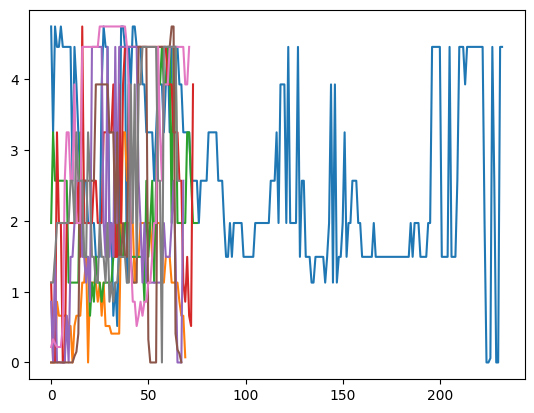

In [4]:
for e, eddy in enumerate(dic_sample.keys()):
    dic = dic_sample[eddy]
    depths = []
    for d, day in enumerate(dic.keys()):
        df = dic[day].copy()
        if len(df):
            depths.append(-df.iloc[-1]['Depth']/1000)
        else:
            depths.append(0)
    plt.plot(depths)


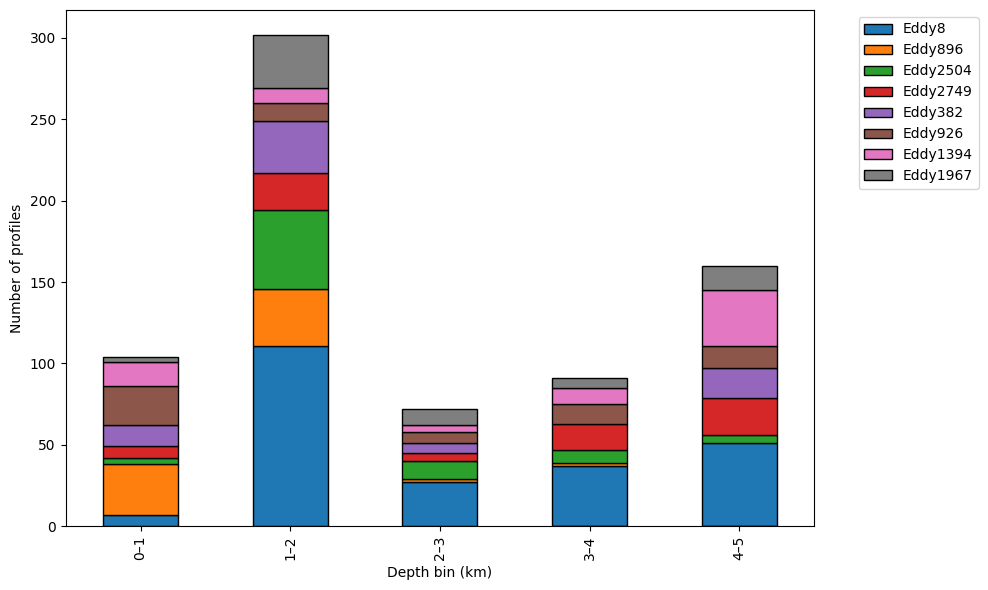

In [5]:
# Adjustable bin width
bin_width = 1  # km
max_depth_km = 5  # adjust as needed

# Create bin edges and labels
bins = np.arange(0, max_depth_km + bin_width, bin_width)
bin_labels = [f"{round(b,1)}–{round(b+bin_width,1)}" for b in bins[:-1]]

# Prepare DataFrame
eddy_names = list(dic_sample.keys())
bin_counts = pd.DataFrame(0, index=bin_labels, columns=eddy_names)

# Fill in counts
for eddy in eddy_names:
    dic = dic_sample[eddy]
    depths = []
    for day in dic:
        df = dic[day].copy()
        if len(df):
            depth_km = -df.iloc[-1]['Depth'] / 1000
            depths.append(depth_km)
        else:
            depths.append(0)

    counts, _ = np.histogram(depths, bins=bins)
    bin_counts.loc[:, eddy] = counts

# Plot
bin_counts.plot(kind='bar', stacked=True, figsize=(10, 6), edgecolor='black')
plt.xlabel('Depth bin (km)')
plt.ylabel('Number of profiles')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

#### Ellipticity

##### Depth

In [6]:
df_means = pd.DataFrame([
    {
        'Eddy': eddy,
        'x_mean': df_all['x'].mean(),
        'y_mean': df_all['y'].mean()
    }
    for eddy, days in dic_sample.items()
    for df_all in [pd.concat(
        [df0 for df0 in days.values() 
         if not df0.empty and not df0.isna().all().all()],
        ignore_index=True
    )]
])


In [7]:
for eddy in sample_eddies:
    eddy = f'Eddy{eddy}'
    
    dic = dic_sample[eddy]

    for day in dic.keys():
        df = dic[day]

        if len(df):

            Qs = df['Q'].values.copy()
            Rcs = df['Rc'].values.copy()
            psi0s = df['psi0'].values.copy()
            depths = -df['Depth'].values.copy() / 1000  # in km
            
            # smooth against frame index t
            window = 50
            sq11  = smooth([q[0,0] for q in Qs], depths, num=1000, window=window)
            sq12  = smooth([q[0,1] for q in Qs], depths, num=1000, window=window)
            sq22  = smooth([q[1,1] for q in Qs], depths, num=1000, window=window)
    
            df['sw'] = 2 * (sq11 + sq22)
            df['sQ'] = [np.array([[sq11[i], sq12[i]], [sq12[i], sq22[i]]]) for i in range(len(sq11))]
            
            mask = Rcs > Rc_max
            Rcs[mask] = np.nan
            psi0s[mask] = np.nan
            df['sRc']   = smooth(Rcs,                    depths, window=window)
            df['spsi0'] = smooth(psi0s,                  depths, window=window)

            

/home/z5297792/.local/lib/python3.10/site-packages/scipy/interpolate/_interpolate.py:712: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/z5297792/.local/lib/python3.10/site-packages/scipy/interpolate/_interpolate.py:712: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/z5297792/.local/lib/python3.10/site-packages/scipy/interpolate/_interpolate.py:712: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/home/z5297792/.local/lib/python3.10/site-packages/scipy/interpolate/_interpolate.py:712: RuntimeWarning: invalid value encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


In [8]:
sample_eddies

[8, 896, 2504, 2749, 382, 926, 1394, 1967]

In [9]:
eddy = 8
k = 100

dic_sample[f'Eddy{eddy}'][list(dic_sample[f'Eddy{eddy}'].keys())[k]].head()


,x,y,Q,w,Rc,psi0,z,Depth,TD,sw,sQ,sRc,spsi0
0,269.362417,362.298931,"[[0.01107515439072258, 0.0010889037699903668],...",0.043217,3.216872,-273.479238,0,-1.783320,0.000000,0.043987,"[[0.011287258838376451, 0.0014734023012166362]...",3.217310,-336.311459
1,270.074347,363.259484,"[[0.01106515721953918, 0.0012946042726859485],...",0.043317,3.217486,-315.640614,1,-5.879627,1.195620,0.044031,"[[0.011298001431019852, 0.0014918886907896675]...",3.217303,-335.250438
2,270.352469,363.794133,"[[0.011265779873584096, 0.0013936420812560128]...",0.043801,3.217388,-359.263879,2,-10.725783,1.793274,0.044077,"[[0.011308652257369848, 0.0015113321770282514]...",3.217299,-334.466203
3,270.489390,364.186556,"[[0.011313637024535847, 0.0014548269342192837]...",0.043965,3.217404,-360.875828,3,-16.383097,2.198453,0.044120,"[[0.01131886444067178, 0.0015304672904842376],...",3.217297,-334.113906
4,270.524027,364.595892,"[[0.011348209280109482, 0.0015664266978713019]...",0.044222,3.217408,-358.466539,4,-22.925581,2.573979,0.044156,"[[0.011328277197876718, 0.0015461827760621825]...",3.217298,-334.463622


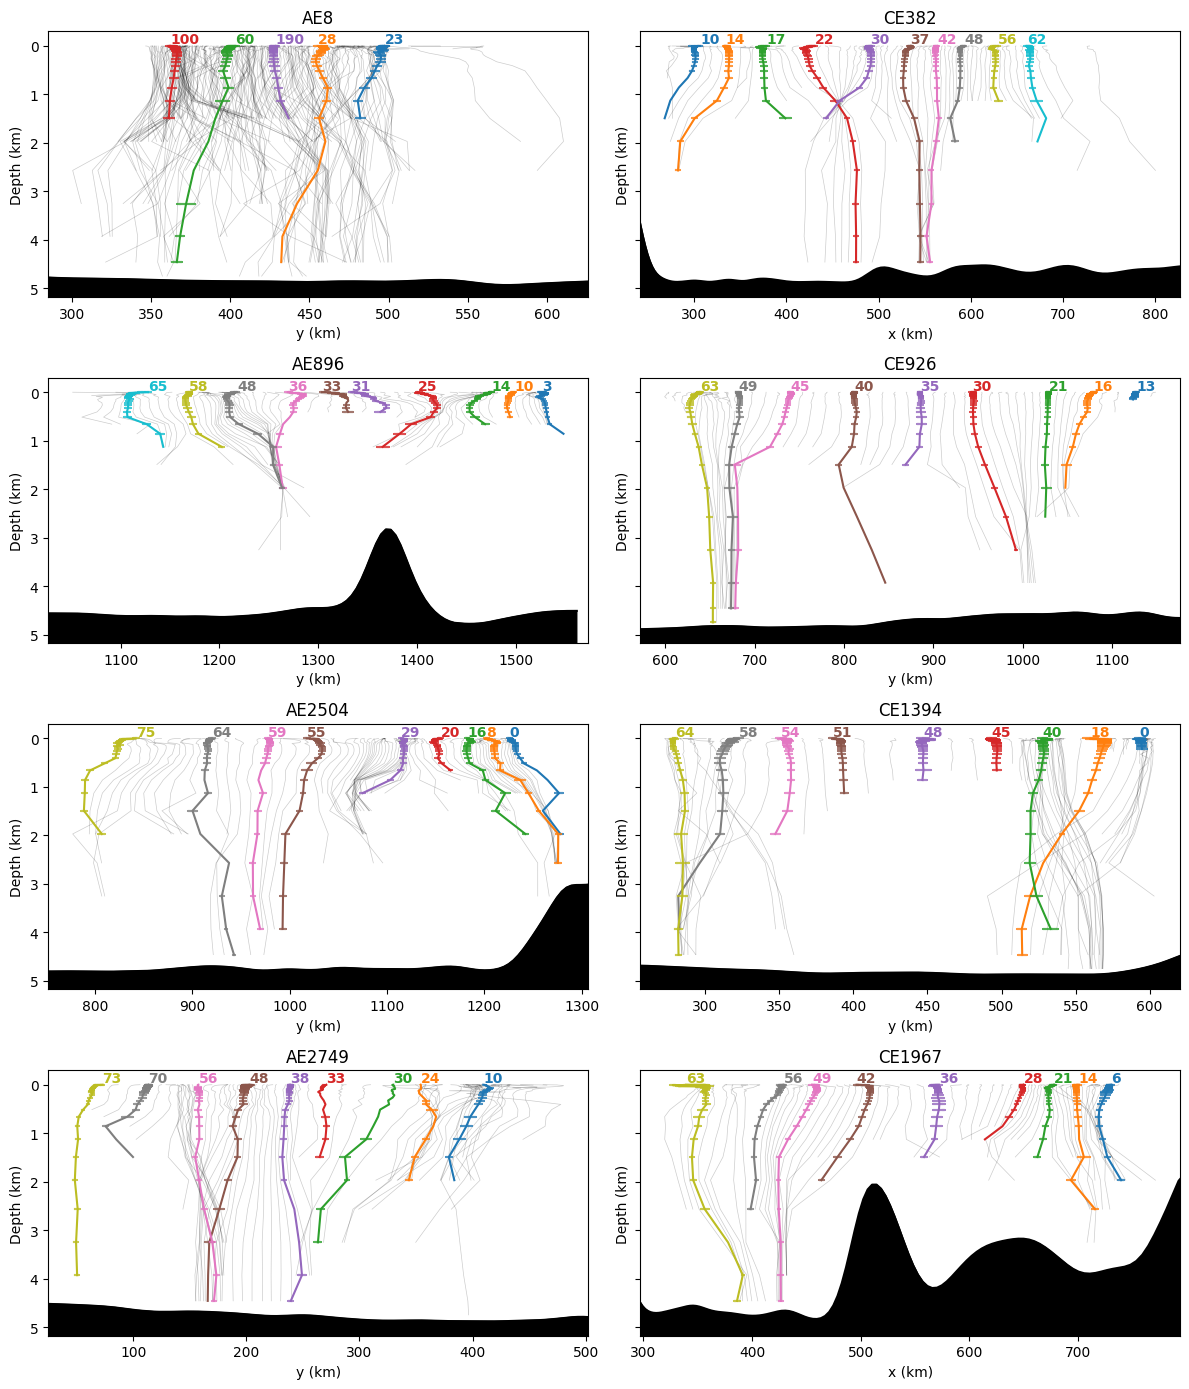

In [10]:
fig, axs = plt.subplots(4, 2, figsize=(12,14), sharey=True)

eddy_p = sample_eddies

days_p = [[23, 28, 60, 100, 190],
          [3, 10, 14, 25, 31, 33, 36, 48, 58, 65],
          [0,  8, 16, 20, 29, 55, 59, 64, 75],
          [10, 24, 30, 33, 38, 48, 56, 70, 73],
          [10, 14, 17, 22, 30, 37, 42, 48, 56, 62],
          [13, 16, 21, 30, 35, 40, 45, 49, 63],
          [0, 18, 40, 45, 48, 51, 54, 58, 64],
          [6, 14, 21, 28, 36, 42, 49, 56, 63]]
          
for e, (eddy, days) in enumerate(zip(eddy_p, days_p)):

    ax = axs[e % 4, e // 4]

    eddy = f'Eddy{eddy}'
    
    pmean = df_means[df_means['Eddy']==eddy].iloc[0]
    
    dic = dic_sample[eddy]

    for day in dic.keys():
        if int(day[3:]) not in days:
            df = dic[day].copy()
            if ('1967' in eddy) or ('382' in eddy):
                ax.plot(df.x, -df.Depth/1000, linewidth=.5, color='k', alpha=.2)
            else:
                ax.plot(df.y, -df.Depth/1000, linewidth=.5, color='k', alpha=.2)
    
    colors = plt.get_cmap('tab10').colors
    for d, day_idx in enumerate(days):
        
        day_key = list(dic_sample[eddy].keys())[day_idx]
        df = dic[day_key].copy()
    
        if len(df):
            
            # raw data
            xs = df['x'].values.copy()
            ys = df['y'].values.copy()
            sQs = df['sQ'].values.copy()
            sq11 = [q[0,0] for q in sQs]
            sq12 = [q[0,1] for q in sQs]
            sq22 = [q[1,1] for q in sQs]
            sRc = df['sRc'].values.copy()
            spsi0 = df['spsi0'].values.copy()
            depths = -df['Depth'].values.copy() / 1000  # in km

            # plot each smoothed ellipse at its depth
            if ('1967' in eddy) or ('382' in eddy):
                ax.plot(xs, depths, color=colors[d % 10], label=day_idx)
                ax.text(xs[0], -.05, day_idx, color=colors[d % 10], fontweight='bold')
            else:
                ax.plot(ys, depths, color=colors[d % 10], label=day_idx)
                ax.text(ys[0], -.05, day_idx, color=colors[d % 10], fontweight='bold')
            for x0, y0, q11, q12, q22, Rc, z0 in zip(xs, ys, sq11, sq12, sq22, sRc, depths):
                Qm = np.array([[q11, q12],[q12, q22]])
                xe, ye = plot_ellipse(Qm, (x0, y0), scale=Rc)
                ze = np.full_like(xe, z0)
                if ('1967' in eddy) or ('382' in eddy):
                    ax.plot(xe, ze, color=colors[d % 10], alpha=0.8)
                else:
                    ax.plot(ye, ze, color=colors[d % 10], alpha=0.8)

    xlim = ax.get_xlim()
    
    if ('1967' in eddy) or ('382' in eddy):
        jc = np.where(np.abs(pmean['y_mean']-y_grid)==np.min(np.abs(pmean['y_mean']-y_grid)))[0][0]
        ax.plot(x_grid, h[:, jc]/1000, 'k', )
    else:
        ic = np.where(np.abs(pmean['x_mean']-x_grid)==np.min(np.abs(pmean['x_mean']-x_grid)))[0][0]
        ax.plot(y_grid, h[ic, :]/1000, 'k')
    
    ylim = ax.get_ylim()
    
    if ('1967' in eddy) or ('382' in eddy):
        jc = np.where(np.abs(pmean['y_mean'] - y_grid) == np.min(np.abs(pmean['y_mean'] - y_grid)))[0][0]
        ax.fill_between(x_grid, h[:, jc] / 1000, 10, color='k')
    else:
        ic = np.where(np.abs(pmean['x_mean'] - x_grid) == np.min(np.abs(pmean['x_mean'] - x_grid)))[0][0]
        ax.fill_between(y_grid, h[ic, :] / 1000, 10, color='k')
        
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    if ('1967' in eddy) or ('382' in eddy):
        ax.set_xlabel('x (km)')
    else:
        ax.set_xlabel('y (km)')
    
    ax.set_ylabel('Depth (km)')
    cyc = df_eddies.loc[df_eddies['ID'] == int(eddy[4:]), 'Cyc'].iloc[0]
    ax.set_title(f'{cyc}{eddy[4:]}')
    # ax.legend(title='Day', loc='lower right', ncol=2)
    
axs[0,0].invert_yaxis()
axs[0,0].set_ylim(None, -.3)
    
plt.tight_layout()
plt.show()
    

##### Surface

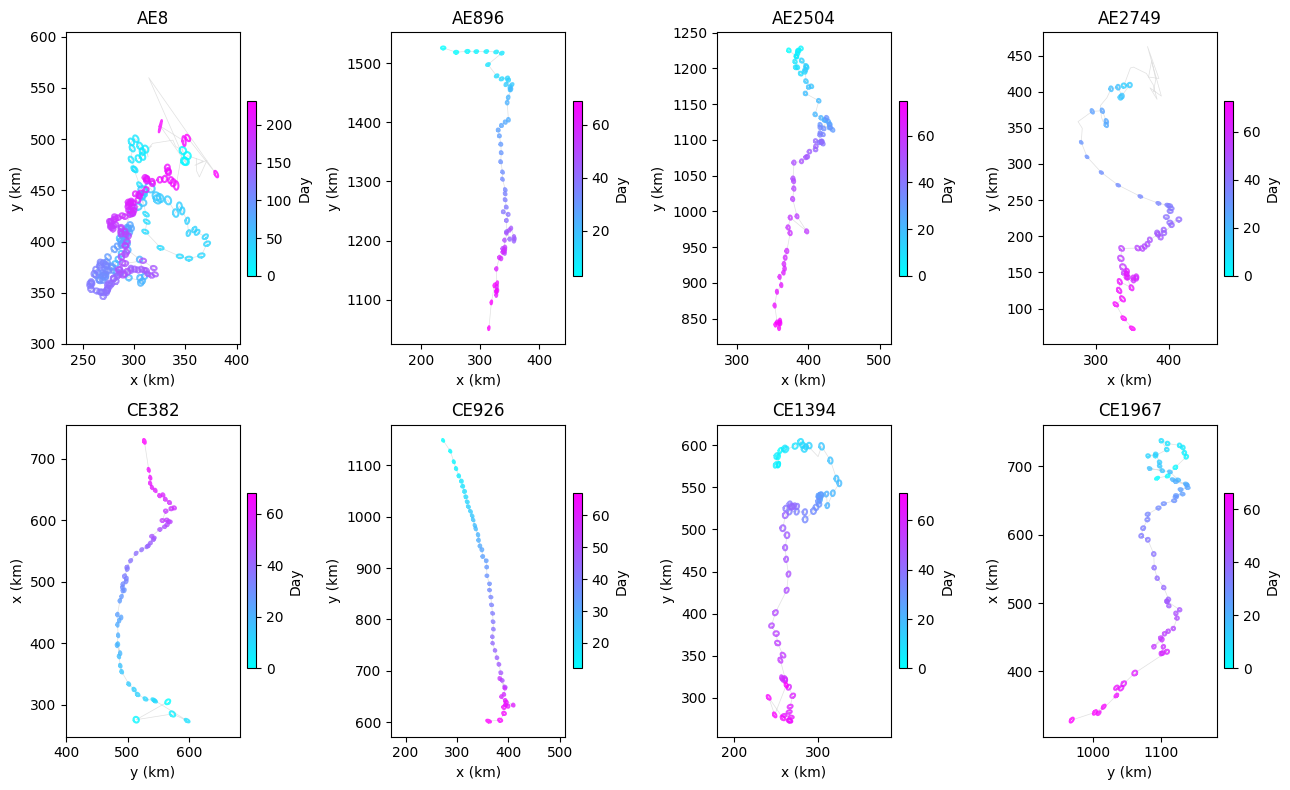

In [11]:
from matplotlib.cm import cool
from matplotlib.colors import Normalize

fig, axs = plt.subplots(2, 4, figsize=(13, 8))

for e, eddy in enumerate(dic_sample):
    ax = axs[e // 4, e % 4]
    xs, ys, Qs, Rcs, ds = [], [], [], [], []
    for d, day in enumerate(dic_sample[eddy]):
        df = dic_sample[eddy][day]
        if df.empty:
            continue
        xs.append(df.iloc[0]['x'])
        ys.append(df.iloc[0]['y'])

        Q = df.iloc[0]['sQ']
        if not np.any(np.isnan(Q)):
            Qs.append(np.array(Q))
        else:
            Qs.append(df.iloc[0]['Q'])
        
        Rc = df.iloc[0]['sRc']
        if not np.isnan(Rc):
            Rcs.append(Rc)
        else:
            Rcs.append(df.iloc[0]['Rc'])
            
        ds.append(d)

    if not ds:
        ax.set_title(eddy)
        continue

    if ('382' in eddy) or ('1967' in eddy):
        ax.plot(ys, xs, linewidth=.5, color='lightgray', alpha=.7)
        ax.set_xlabel('y (km)')
        ax.set_ylabel('x (km)')
    else:
        ax.plot(xs, ys, linewidth=.5, color='lightgray', alpha=.7)
        ax.set_xlabel('x (km)')
        ax.set_ylabel('y (km)')

    days = np.array(ds)
    window = 5
    sq11 = smooth([q[0,0] for q in Qs], days, num=len(days), window=window)
    sq12 = smooth([q[0,1] for q in Qs], days, num=len(days), window=window)
    sq22 = smooth([q[1,1] for q in Qs], days, num=len(days), window=window)

    Rcs = np.array(Rcs)
    Rcs[Rcs > Rc_max] = np.nan
    sRc  = smooth(Rcs,       days, num=len(days), window=window)

    norm = Normalize(vmin=days.min(), vmax=days.max())
    cmap = cool
    sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array(days)

    for xi, yi, a, b, c, scale, day in zip(xs, ys, sq11, sq12, sq22, sRc, ds):
        Qm = np.array([[a, b], [b, c]])
        xe, ye = plot_ellipse(Qm, (xi, yi), scale=scale)
        if ('382' in eddy) or ('1967' in eddy):
            ax.plot(ye, xe, color=cmap(norm(day)), alpha=.8)
        else:
            ax.plot(xe, ye, color=cmap(norm(day)), alpha=.8)

    cbar = fig.colorbar(
        sm, ax=ax,
        orientation='vertical',
        fraction=0.046,
        pad=0.04
    )
    cbar.set_label('Day')
    cbar.ax.yaxis.set_ticks_position('right')
    cbar.ax.yaxis.set_label_position('right')

    ax.axis('equal')
    cyc = df_eddies.loc[df_eddies['ID'] == int(eddy[4:]), 'Cyc'].iloc[0]
    ax.set_title(f'{cyc}{eddy[4:]}')

plt.tight_layout()
plt.show()


#### Volitility

In [12]:
diffs_x = {}
diffs_y = {}

num = 6
depth_int = 10
max_depth = 5000
target_depths = np.arange(0, max_depth+1, depth_int)

for eddy, dic in dic_sample.items():
    for d, (day, df0) in enumerate(dic.items()):
        df = df0.copy()
        df['Depth'] = -df['Depth']
        df = df[df['Depth'] <= max_depth]
        df = df.set_index('Depth').sort_index()

        key = f'{eddy}_Day{d}'
        if len(df) < 2:
            # not enough points to interpolate — fill with NaNs
            idx = target_depths[:-1]
            diffs_x[key] = pd.Series(np.nan, index=idx)
            diffs_y[key] = pd.Series(np.nan, index=idx)
            continue

        depths = df.index.values
        # we interpolate at every depth_int m, but only
        # need at least two points to diff
        x_i = np.interp(target_depths, depths, df['x'].values)
        y_i = np.interp(target_depths, depths, df['y'].values)

        dx = np.diff(x_i)
        dy = np.diff(y_i)
        idx = target_depths[:-1]

        diffs_x[key] = pd.Series(dx, index=idx)
        diffs_y[key] = pd.Series(dy, index=idx)

# build DataFrames, and then reindex to ensure every 10 m bin appears
full_idx = target_depths[:-1]
df_X_all = pd.DataFrame(diffs_x).reindex(full_idx)
df_Y_all = pd.DataFrame(diffs_y).reindex(full_idx)


In [13]:
df_X_all.head()


,Eddy8_Day0,Eddy8_Day1,Eddy8_Day2,Eddy8_Day3,Eddy8_Day4,Eddy8_Day5,Eddy8_Day6,Eddy8_Day7,Eddy8_Day8,Eddy8_Day9,...,Eddy1967_Day57,Eddy1967_Day58,Eddy1967_Day59,Eddy1967_Day60,Eddy1967_Day61,Eddy1967_Day62,Eddy1967_Day63,Eddy1967_Day64,Eddy1967_Day65,Eddy1967_Day66
0,-2.781650,0.234387,-0.196948,-4.296924,1.684536,-2.019094,1.295215,1.977013,-1.614895,-4.334050,...,NaN,7.502598,8.635234,6.757414,-1.747446,-0.763363,-7.550004,-1.069633,5.545296,11.565159
10,-5.545472,-0.127038,2.084133,-1.132980,3.015782,-0.291710,1.410839,0.883197,-0.769241,-4.133892,...,NaN,-0.282733,1.586521,-0.624073,-0.168091,0.322740,23.022514,1.682763,-0.570694,7.128241
20,0.293949,-0.404782,0.810730,-0.444586,0.799427,-0.456968,2.796018,-1.920729,-0.295149,-0.372377,...,NaN,-0.735876,-0.731800,0.095849,0.006965,0.215654,-20.603674,-1.428634,0.998948,0.987247
30,4.785962,0.514526,0.000638,-0.480077,0.250257,-0.273791,2.029314,1.218664,-0.374456,-1.073594,...,NaN,-1.305872,-0.875696,-0.201984,-1.309073,-1.778422,17.681158,0.661408,1.205040,0.615259
40,0.413154,0.413839,-1.952836,0.522247,0.052887,-0.225586,-0.204372,2.428303,-0.397294,2.271745,...,NaN,-1.033332,0.202028,-0.127185,0.121820,1.150243,6.112919,0.845197,2.095738,-0.078415


In [14]:
df_data = pd.DataFrame()
for eddy in dic_sample.keys():
    df_eddy_x = df_X_all[[col for col in df_X_all.columns if eddy in col]].copy()
    df_data[f'x_{eddy}_mean'] = df_eddy_x.mean(axis=1)
    df_data[f'x_{eddy}_std'] = df_eddy_x.std(axis=1)
    df_eddy_y = df_Y_all[[col for col in df_Y_all.columns if eddy in col]].copy()
    df_data[f'y_{eddy}_mean'] = df_eddy_y.mean(axis=1)
    df_data[f'y_{eddy}_std'] = df_eddy_y.std(axis=1)
df_data.head()


,x_Eddy8_mean,x_Eddy8_std,y_Eddy8_mean,y_Eddy8_std,x_Eddy896_mean,x_Eddy896_std,y_Eddy896_mean,y_Eddy896_std,x_Eddy2504_mean,x_Eddy2504_std,...,y_Eddy926_mean,y_Eddy926_std,x_Eddy1394_mean,x_Eddy1394_std,y_Eddy1394_mean,y_Eddy1394_std,x_Eddy1967_mean,x_Eddy1967_std,y_Eddy1967_mean,y_Eddy1967_std
0,-0.348324,2.639926,0.453921,3.433392,-0.782417,2.993617,2.627385,5.987917,-0.520914,2.913501,...,0.344871,2.732851,-0.157360,2.029293,0.219110,2.511093,0.455456,3.518527,0.618257,3.901760
10,-0.224689,1.275618,0.285742,2.904355,-0.492071,1.558713,1.495985,3.824981,-0.164262,1.124770,...,-0.013920,0.810531,0.011557,0.959773,0.364097,1.248245,0.545429,3.424527,0.661919,3.408534
20,-0.062698,1.197432,-0.073793,1.476114,-0.608208,1.290453,0.716025,2.057756,0.066595,0.745159,...,-0.099597,0.828106,0.055308,1.025083,0.295461,1.050438,-0.111037,2.868789,0.099607,2.448761
30,-0.128663,1.145408,0.025004,1.431647,-0.501972,1.393481,0.271097,2.125238,0.050069,0.830982,...,-0.110518,1.097094,-0.155149,1.037140,-0.199252,1.053257,0.244727,2.500379,0.334707,1.728807
40,-0.028268,0.859362,-0.037695,1.074508,-0.363390,1.549146,0.086196,1.805916,0.031486,0.639003,...,-0.312878,1.031657,0.051074,0.652292,-0.301698,1.213131,0.142455,1.228525,0.342664,1.733748


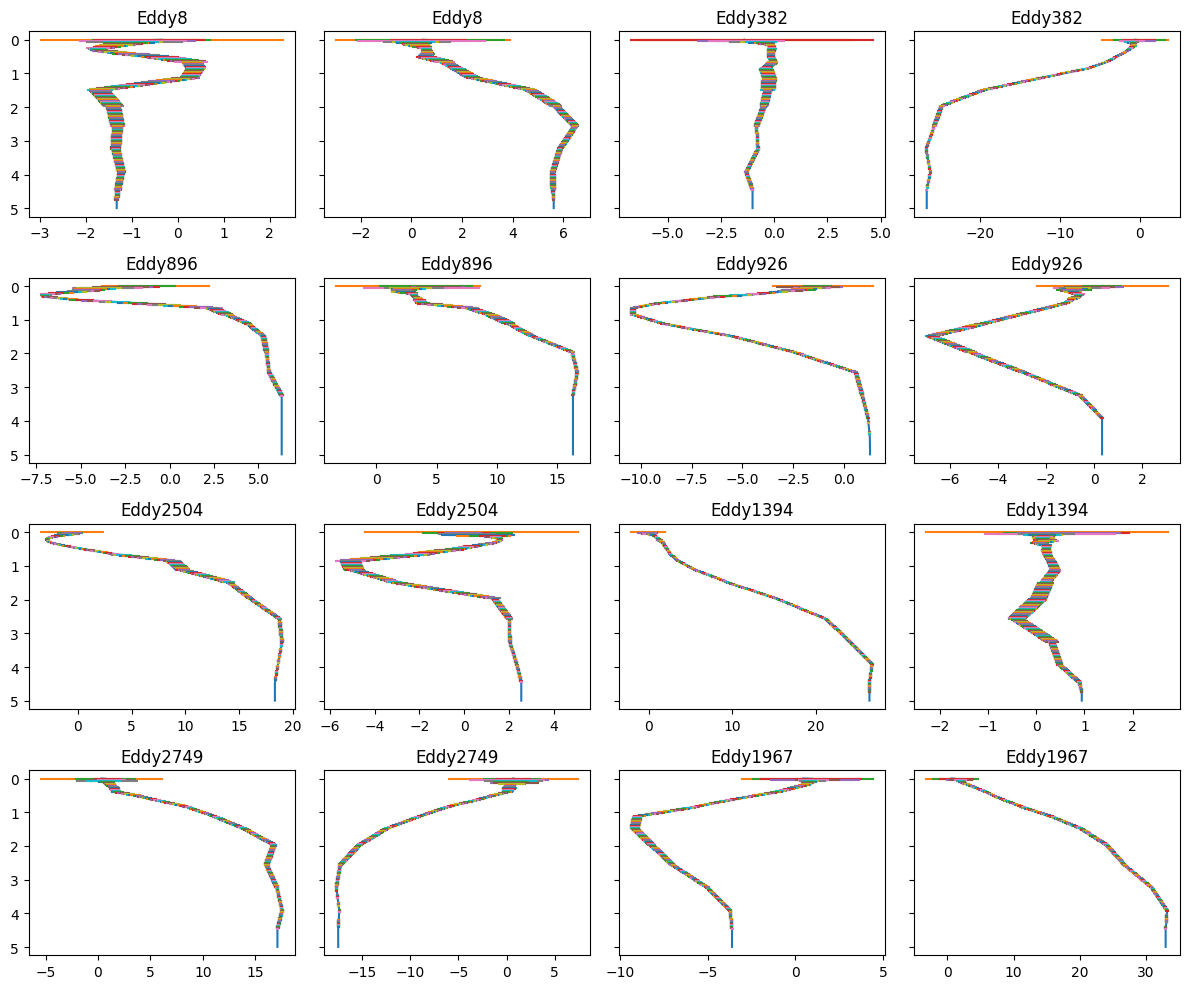

In [15]:
fig, axs = plt.subplots(4,4, figsize=(12,10), sharey=True)
for e, eddy in enumerate(dic_sample.keys()):
    ax0 = axs[e % 4, (e//4)*2]
    ax1 = axs[e % 4, 1+(e//4)*2]

    ax0.set_title(eddy)
    ax1.set_title(eddy)

    x_mean = df_data[f'x_{eddy}_mean']
    x_std = df_data[f'x_{eddy}_std']
    y_mean = df_data[f'y_{eddy}_mean']
    y_std = df_data[f'y_{eddy}_std']

    ax0.plot(x_mean.cumsum(), df_data.index/1000)
    for (r, x, z) in zip(x_std, x_mean.cumsum(), df_data.index/1000):
        ax0.plot([x-r, x+r], [z, z])
    ax1.plot(y_mean.cumsum(), df_data.index/1000)
    for (r, y, z) in zip(y_std, y_mean.cumsum(), df_data.index/1000):
        ax1.plot([y-r, y+r], [z, z])

axs[0,0].invert_yaxis()
plt.tight_layout()


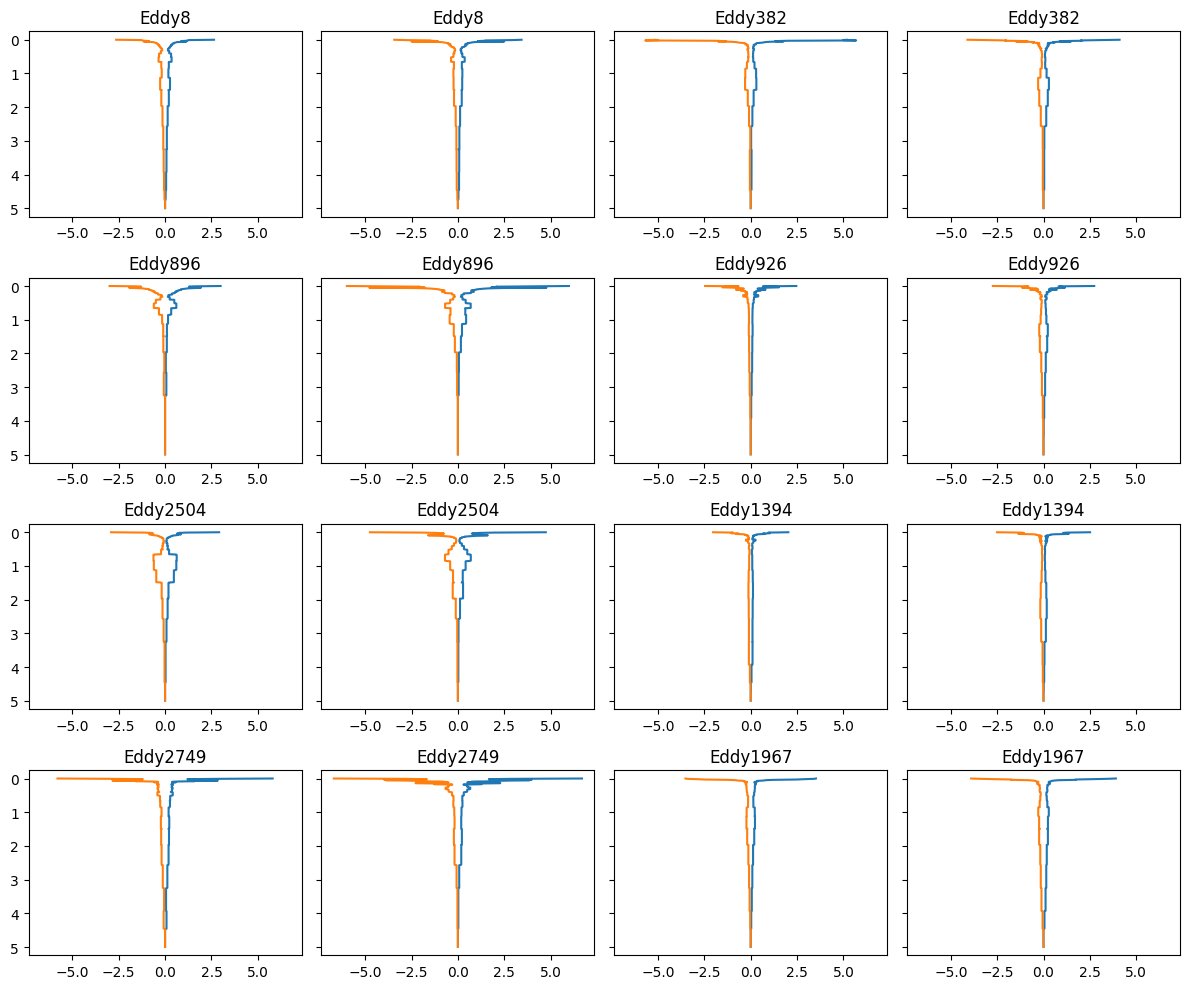

In [16]:
fig, axs = plt.subplots(4,4, figsize=(12,10), sharey=True)
xmax = 0
for e, eddy in enumerate(dic_sample.keys()):
    ax0 = axs[e % 4, (e//4)*2]
    ax1 = axs[e % 4, 1+(e//4)*2]

    ax0.set_title(eddy)
    ax1.set_title(eddy)

    x_mean = df_data[f'x_{eddy}_mean']
    x_std = df_data[f'x_{eddy}_std']
    y_mean = df_data[f'y_{eddy}_mean']
    y_std = df_data[f'y_{eddy}_std']

    ax0.plot(x_std, df_data.index/1000)
    ax0.plot(-x_std, df_data.index/1000)
    ax1.plot(y_std, df_data.index/1000)
    ax1.plot(-y_std, df_data.index/1000)

    xmax = max(xmax, ax0.get_xlim()[1], ax1.get_xlim()[1])
for ax in axs.flat:
    ax.set_xlim(-xmax, xmax)

axs[0,0].invert_yaxis()
plt.tight_layout()


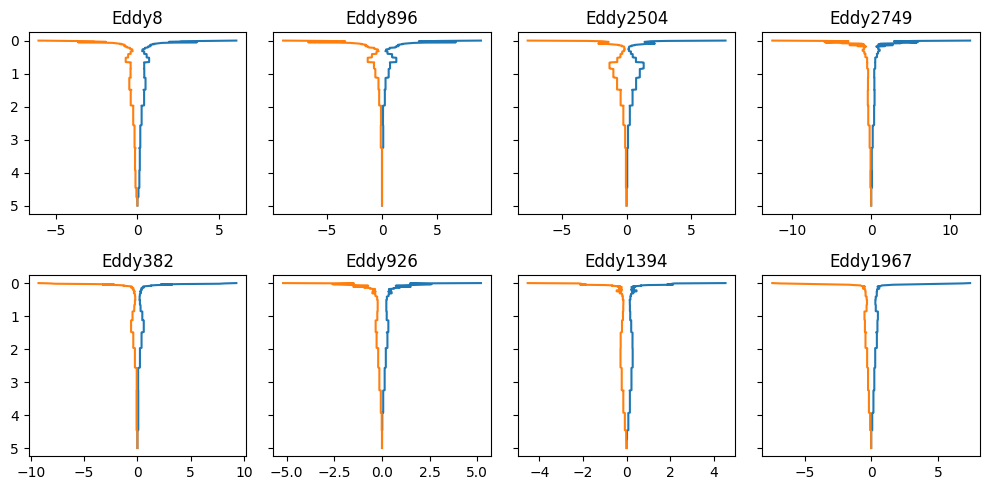

In [17]:
fig, axs = plt.subplots(2, 4, figsize=(10,5), sharey=True)     
for e, eddy in enumerate(dic_sample.keys()):
    ax = axs[e // 4, e % 4]
    ax.set_title(eddy)

    x_mean = df_data[f'x_{eddy}_mean']
    x_std = df_data[f'x_{eddy}_std']
    y_mean = df_data[f'y_{eddy}_mean']
    y_std = df_data[f'y_{eddy}_std']

    ax.plot(x_std+y_std, df_data.index/1000)
    ax.plot(-x_std-y_std, df_data.index/1000)

axs[0,0].invert_yaxis()
plt.tight_layout()


#### Velocity Field

In [18]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
fnumber_old = 0

In [ ]:
eddy = 8
day_idx = 65
r = 140

dic = dic_sample[f'Eddy{eddy}']
day = list(dic.keys())[day_idx]
df = dic[day].copy()
day = int(day[3:])

fname = df_eddies[(df_eddies['ID']==eddy)&(df_eddies['Day']==day)].iloc[0]['fname']

fnumber = fname[-8:-3]
if fnumber != fnumber_old:

    u_raw = np.load('/srv/scratch/z5297792/Climatology/u_v/u_' + fnumber + '.npy')
    v_raw = np.load('/srv/scratch/z5297792/Climatology/u_v/v_' + fnumber + '.npy')
    
    u_raw = np.where(np.abs(u_raw) > 1e30, np.nan, u_raw).astype(float)
    v_raw = np.where(np.abs(v_raw) > 1e30, np.nan, v_raw).astype(float)
    
    with nc.Dataset(fname) as dataset:
        ocean_time = dataset.variables['ocean_time'][:].data / 86400
    fnumber_old = fnumber
t_rel = np.where(ocean_time == day)[0][0]

u_t, v_t = u_raw[:, :, :, t_rel], v_raw[:, :, :, t_rel]

xc_surf, yc_surf = df.iloc[0].x, df.iloc[0].y
ic = np.where(np.abs(x_grid-xc_surf)==np.min(np.abs(x_grid-xc_surf)))[0][0]
jc = np.where(np.abs(y_grid-yc_surf)==np.min(np.abs(y_grid-yc_surf)))[0][0]

x_mask = np.where(np.abs(x_grid - xc_surf) < r)[0]
y_mask = np.where(np.abs(y_grid - yc_surf) < r)[0]

fig, axs = plt.subplots(1, 2, sharey=True)
axs[0].contourf(x_grid[x_mask], -z_r/1000, v_t[x_mask, jc, :].T)
axs[0].plot(df.x, -df.Depth/1000, color='r')
axs[0].set_xlabel('x (km)')
axs[0].set_ylabel('Depth (km)')
axs[0].invert_yaxis()
axs[1].contourf(y_grid[y_mask], -z_r/1000, u_t[ic, y_mask, :].T)
axs[1].plot(df.y, -df.Depth/1000, color='r')
axs[1].set_xlabel('y (km)')

axs[0].plot(x_grid[x_mask], h[x_mask, jc]/1000, 'k')
axs[1].plot(y_grid[y_mask], h[ic, y_mask]/1000, 'k')
ylim0 = axs[0].get_ylim()
ylim1 = axs[1].get_ylim()
axs[0].fill_between(x_grid[x_mask], h[x_mask, jc]/1000, 10, color='k')
axs[1].fill_between(y_grid[y_mask], h[ic, y_mask]/1000, 10, color='k')
axs[0].set_ylim(ylim0)
axs[1].set_ylim(ylim1)

plt.tight_layout()


In [ ]:
sample_eddies

In [ ]:
fig, axs = plt.subplots(4, 4, figsize=(12,10), sharey=True)
colors = plt.get_cmap('tab10').colors
fnumber_old = None

for e, (eddy, day_idx) in enumerate(zip(eddy_p, day_idx_p)):
    
    ax0 = axs[e % 4, (e//4)*2]
    ax1 = axs[e % 4, 1+(e//4)*2]
    r = 140

    ax0.set_title(f'Eddy{eddy}, Day {day_idx}')
    ax1.set_title(f'Eddy{eddy}, Day {day_idx}')
    
    dic = dic_sample[f'Eddy{eddy}']
    day = list(dic.keys())[day_idx]
    df = dic[day].copy()
    day = int(day[3:])
    
    fname = df_eddies[(df_eddies['ID']==eddy)&(df_eddies['Day']==day)].iloc[0]['fname']
    
    fnumber = fname[-8:-3]
    if fnumber != fnumber_old:
    
        u_raw = np.load('/srv/scratch/z5297792/Climatology/u_v/u_' + fnumber + '.npy')
        v_raw = np.load('/srv/scratch/z5297792/Climatology/u_v/v_' + fnumber + '.npy')
        
        u_raw = np.where(np.abs(u_raw) > 1e30, np.nan, u_raw).astype(float)
        v_raw = np.where(np.abs(v_raw) > 1e30, np.nan, v_raw).astype(float)
        
        with nc.Dataset(fname) as dataset:
            ocean_time = dataset.variables['ocean_time'][:].data / 86400
        fnumber_old = fnumber
    t_rel = np.where(ocean_time == day)[0][0]
    
    u_t, v_t = u_raw[:, :, :, t_rel], v_raw[:, :, :, t_rel]
    
    xc_surf, yc_surf = df.iloc[0].x, df.iloc[0].y
    ic = np.where(np.abs(x_grid-xc_surf)==np.min(np.abs(x_grid-xc_surf)))[0][0]
    jc = np.where(np.abs(y_grid-yc_surf)==np.min(np.abs(y_grid-yc_surf)))[0][0]
    
    x_mask = np.where(np.abs(x_grid - xc_surf) < r)[0]
    y_mask = np.where(np.abs(y_grid - yc_surf) < r)[0]
    
    # symmetric limits
    vmax_v = np.nanmax(np.abs(v_t[x_mask, jc, :]))
    vmax_u = np.nanmax(np.abs(u_t[ic, y_mask, :]))
    
    # v‐slice
    im0 = ax0.contourf(
        x_grid[x_mask],
        -z_r/1000,
        v_t[x_mask, jc, :].T,
        cmap='coolwarm',
        vmin=-vmax_v,
        vmax=+vmax_v
    )
    ax0.plot(df.x, -df.Depth/1000, color=colors[e])
    ax0.set_xlabel('x (km)')
    ax0.set_ylabel('Depth (km)')
    ax0.plot(x_grid[x_mask], h[x_mask, jc]/1000, 'k')
    ax0.fill_between(x_grid[x_mask], h[x_mask, jc]/1000, 10, color='k')
    ax0.set_ylim(ax0.get_ylim())
    
    # vertical colourbar on the right
    cbar0 = fig.colorbar(
        im0,
        ax=ax0,
        orientation='vertical',  # default but explicit here
        pad=0.02,                # small gap to the right
        shrink=0.8               # scale to fit subplot height
    )
    cbar0.set_label('v (m/s)')
    
    # u‐slice
    im1 = ax1.contourf(
        y_grid[y_mask],
        -z_r/1000,
        u_t[ic, y_mask, :].T,
        cmap='coolwarm',
        vmin=-vmax_u,
        vmax=+vmax_u
    )
    ax1.plot(df.y, -df.Depth/1000, color=colors[e])
    ax1.set_xlabel('y (km)')
    ax1.plot(y_grid[y_mask], h[ic, y_mask]/1000, 'k')
    ax1.fill_between(y_grid[y_mask], h[ic, y_mask]/1000, 10, color='k')
    ax1.set_ylim(0, 5)
    
    # vertical colourbar on the right
    cbar1 = fig.colorbar(
        im1,
        ax=ax1,
        orientation='vertical',
        pad=0.02,
        shrink=0.8
    )
    cbar1.set_label('u (m/s)')

# invert y once at the end
axs[0,0].invert_yaxis()
plt.tight_layout()
plt.show()
